In [14]:
from langgraph.graph import StateGraph,START,END,MessagesState
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode,tools_condition
from dotenv import load_dotenv
from langchain_core.messages import AIMessage,HumanMessage
import os,requests
load_dotenv()

True

In [2]:
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash')

In [7]:
from langchain_community.tools import DuckDuckGoSearchRun
search_tool = DuckDuckGoSearchRun(region="us-en")

In [9]:
@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}




In [10]:
ALPHAVANTAGE_STOCK_KEY = os.getenv('ALPHAVANTAGE_STOCK_KEY')
@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={ALPHAVANTAGE_STOCK_KEY}&apikey=C9PE94QUEW9VWGFM"
    r = requests.get(url)
    return r.json()


In [11]:
tools = [get_stock_price,calculator,search_tool]
tool_node = ToolNode(tools)

In [12]:
llm_with_tools = llm.bind_tools(tools)

In [26]:
def LLM(state):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

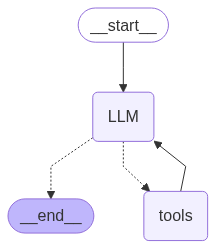

In [27]:
graph = StateGraph(MessagesState)
graph.add_node("LLM",LLM)
graph.add_node("tools",tool_node)
graph.add_edge(START,"LLM")
graph.add_conditional_edges("LLM",tools_condition)
graph.add_edge("tools","LLM")
app = graph.compile()
app

In [28]:
# app.invoke({'messages':['Hi']})
# Regular chat
out = app.invoke({"messages": [HumanMessage(content="Hello!")]})

print(out["messages"][-1].content)

Hi there! How can I help you today?


In [34]:
# Chat requiring tool
out = app.invoke({"messages": [HumanMessage(content="What is the stock price of apple")]})
print(out["messages"][-1].content)

I am unable to retrieve the stock price at this time. Please try again later.


In [ ]:
# Chat requiring tool
out = app.invoke({"messages": [HumanMessage(content="What is 2*3?")]})
for msg in out["messages"]:
    print(msg)

content='What is 2*3?' additional_kwargs={} response_metadata={} id='8e541c68-ccd2-413a-b3bf-59a1fb0c6750'
content='' additional_kwargs={'function_call': {'name': 'calculator', 'arguments': '{"second_num": 3.0, "first_num": 2.0, "operation": "mul"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--0ef9b168-5f1f-4ff8-a14a-379ac6d7dd26-0' tool_calls=[{'name': 'calculator', 'args': {'second_num': 3.0, 'first_num': 2.0, 'operation': 'mul'}, 'id': '8fdc5d7c-b23e-4d71-a9e1-6ddf13f68056', 'type': 'tool_call'}] usage_metadata={'input_tokens': 129, 'output_tokens': 11, 'total_tokens': 140, 'input_token_details': {'cache_read': 0}}
content='{"first_num": 2.0, "second_num": 3.0, "operation": "mul", "result": 6.0}' name='calculator' id='3d6fd5cf-763e-4ca4-9d43-60621ca2e24e' tool_call_id='8fdc5d7c-b23e-4d71-a9e1-6ddf13f68056'
content='2*3 is 6.' additional_kwargs={} response_m